In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/dataset.zip'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: plus/green_3389.png     
 extracting: plus/green_3390.png     
 extracting: plus/green_3399.png     
 extracting: plus/green_3402.png     
 extracting: plus/green_3403.png     
 extracting: plus/green_3404.png     
 extracting: plus/green_3416.png     
 extracting: plus/green_3417.png     
 extracting: plus/green_3420.png     
 extracting: plus/green_3423.png     
 extracting: plus/green_3427.png     
 extracting: plus/green_3428.png     
 extracting: plus/green_3432.png     
 extracting: plus/green_3433.png     
 extracting: plus/green_3434.png     
 extracting: plus/green_3437.png     
 extracting: plus/green_344.png      
 extracting: plus/green_3446.png     
 extracting: plus/green_3447.png     
 extracting: plus/green_3448.png     
 extracting: plus/green_3449.png     
 extracting: plus/green_3452.png     
  inflating: plus/green_3456.png     
 extracting: plus/green_3458.png     
 extracting: plus/green_3460.png     
 extracting: p

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg
import os
import glob
from PIL import Image
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    metrics,
    optimizers,
    utils,
)

# 환경 설정
IMAGE_SIZE = 28  # MNIST 기본 이미지 크기
CHANNELS = 3  # 흑백 이미지
BATCH_SIZE = 128
Z_DIM = 256
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
DATASET_PATH = '/content/plus'

In [18]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(images, save_to=None):
    """
    Displays and saves images using matplotlib. Assumes images are in [0, 1] range.
    """
    n = images.shape[0]
    plt.figure(figsize=(20, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i, :, :, :])  # Display RGB images directly
        plt.axis("off")
    if save_to:
        plt.savefig(save_to)
        print(f"Saved to {save_to}")
    plt.close()  # Close the figure to avoid display

In [19]:
def load_custom_data(dataset_path, image_size=IMAGE_SIZE, channels=CHANNELS):
    """
    Loads images from a custom dataset folder, resizes them, and normalizes to [-1, 1] range.
    """
    image_paths = glob.glob(os.path.join(dataset_path, '*.png'))  # Modify file extension if needed
    images = []

    for image_path in image_paths:
        img = Image.open(image_path).resize((image_size, image_size))
        img = np.array(img).astype(np.float32)
        if img.shape[-1] != channels:  # Ensure the image has the correct number of channels
            continue
        img = (img - 127.5) / 127.5  # Normalize image to [-1, 1]
        images.append(img)

    images = np.array(images)
    train_data = tf.data.Dataset.from_tensor_slices(images)
    train_data = train_data.shuffle(buffer_size=1024).batch(BATCH_SIZE)
    return train_data

In [20]:
train = load_custom_data(DATASET_PATH, IMAGE_SIZE, CHANNELS)

In [21]:
critic_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))  # 입력 채널 수를 3으로 변경
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=7, strides=1, padding="valid")(x)
critic_output = layers.Flatten()(x)
critic = models.Model(critic_input, critic_output)
critic.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 128)           │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 1, 1, 1)             │           6,273 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,609 (549.25 KB)

 Trainable params: 140,609 (549.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
generator_input = layers.Input(shape=(Z_DIM,))
# Dense layer to upscale the input
x = layers.Dense(7 * 7 * 128, use_bias=False)(generator_input)  # 초기 특성 맵 설정 (7x7x256)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Reshape((7, 7, 128))(x)  # 7x7 feature map

# Second Transposed Conv layer to increase dimensions to 28x28
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False  # Adjusted kernel size
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.UpSampling2D()(x)

# Final Transposed Conv layer to get to the desired channel depth
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=1, padding="same", activation="tanh"  # Adjusted to match final output size exactly
)(x)

generator = models.Model(generator_input, generator_output)
generator.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6272)                │       1,605,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6272)                │          25,088 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 14, 14, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,765,123 (6.73 MB)

 Trainable params: 1,752,451 (6.69 MB)

 Non-trainable params: 12,672 (49.50 KB)

In [23]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [24]:
# GAN 만들기
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [25]:
# GAN 컴파일
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [28]:
if not os.path.exists('output'):
    os.makedirs('output')

# 콜백 정의
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 != 0:  # 출력 횟수를 줄이기 위해
            return
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images + 1) / 2  # Normalize images to [0, 1]
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to=f"./output/generated_img_{epoch:03d}.png"
        )

# 모델 저장 체크포인트 및 텐서보드 콜백 설정
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [29]:
# 모델 컴파일 및 콜백 정의는 동일하게 유지
# ...

# 훈련 시작
wgangp.fit(
    train,
    epochs=EPOCHS,  # MNIST 데이터셋 크기에 맞추어 조정
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)


Epoch 1/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - c_gp: 0.7654 - c_loss: -28.2999 - c_wass_loss: -35.9539 - g_loss: -26.8127Saved to ./output/generated_img_000.png
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - c_gp: 0.7656 - c_loss: -28.2779 - c_wass_loss: -35.9335 - g_loss: -26.7697
Epoch 2/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - c_gp: 0.5730 - c_loss: -20.6793 - c_wass_loss: -26.4091 - g_loss: -20.6835
Epoch 3/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - c_gp: 0.4393 - c_loss: -17.6319 - c_wass_loss: -22.0253 - g_loss: -22.9868
Epoch 4/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - c_gp: 0.3550 - c_loss: -14.9548 - c_wass_loss: -18.5044 - g_loss: -23.0885
Epoch 5/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - c_gp: 0.3026 - c_loss: -13.2813 - c_wass_loss: -16.3076 - g_loss: -23.5704
Epoch 6/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - c_gp: 0.2504 - c_loss: -11.5415 - c_wass_loss: -14.0452 - g_loss: -24.8150
Epoch 7/200
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - c_gp: 0.2160 - c

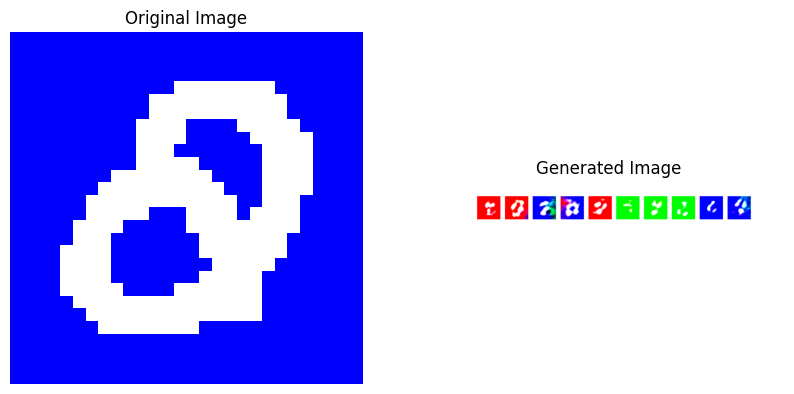

In [30]:
# 이미지 비교 함수
def load_and_compare_images(epoch, example_index=0):
    image_path = f"./output/generated_img_0{epoch}.png"
    if not os.path.exists(image_path):
        print("해당 경로에 이미지 파일이 없습니다:", image_path)
        return

    generated_image = mpimg.imread(image_path)

    # Custom dataset 이미지 로드 및 표시
    original_image_path = glob.glob(os.path.join(DATASET_PATH, '*.png'))[example_index]
    original_image = mpimg.imread(original_image_path)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_image)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(generated_image)
    axs[1].set_title('Generated Image')
    axs[1].axis('off')

    plt.show()

# 예시로 10번째 에포크의 이미지 비교
load_and_compare_images(10, example_index=0)